# 逻辑回归预测银行客户是否会开设定期存款账户

逻辑回归要求预测值为 0 或者 1, 自变量特征值应该彼此独立。 

该数据集来自UCI机器学习库(http://archive.ics.uci.edu/ml/datasets/Bank+Marketing)，葡萄牙银行的电话营销。 分类目标是预测客户是否会开设到定期存款账户（预测值y）。 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
data = pd.read_csv('banking.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


## 输入特征的意义: 

### bank client data:
* 1 - age (numeric)
* 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* 5 - default: has credit in default? (categorical: 'no','yes','unknown')
* 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
* 7 - loan: has personal loan? (categorical: 'no','yes','unknown') 

### related with the last contact of the current campaign:
* 8 - contact: contact communication type (categorical: 'cellular','telephone') 
* 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### other attributes:
* 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; * 999 means client was not previously contacted)
* 14 - previous: number of contacts performed before this campaign and for this client (numeric)
* 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### social and economic context attributes
* 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
* 17 - cons.price.idx: consumer price index - monthly indicator (numeric) 
* 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
* 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
* 20 - nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
* 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [3]:
data['education'].unique()


array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [4]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [5]:
data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

In [6]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

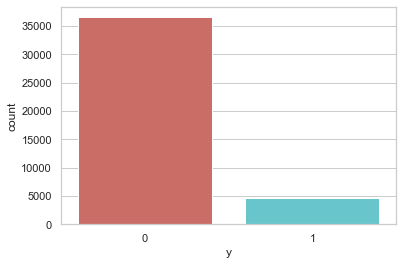

<Figure size 432x288 with 0 Axes>

In [7]:
sns.countplot(x='y', data = data, palette='hls')
plt.show()
plt.savefig('count_plot')

In [8]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print('未开户的百分比:  %.2f%%' % (pct_of_no_sub*100))
pct_of_sub = count_sub/(count_no_sub+count_sub)
print('开户的百分比:  %.2f%%' % (pct_of_sub*100))


未开户的百分比:  88.73%
开户的百分比:  11.27%


In [9]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


# 观察：

购买定期存款的客户的平均年龄高于未购买定期存款的客户的平均年龄。

购买定期存款的客户的 pdays（自上次联系客户以来的日子）较低。 pdays越低，最后一次通话的记忆越好，因此销售的机会就越大。

令人惊讶的是，购买定期存款的客户的销售通话次数较低。

我们可以计算其他特征值（如教育和婚姻状况）的分布，以更详细地了解我们的数据。

In [10]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [11]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [12]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


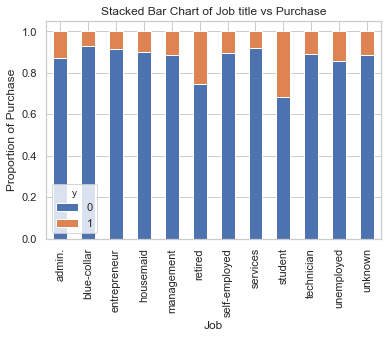

In [13]:
%matplotlib inline
table=pd.crosstab(data.job,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Job title vs Purchase')
plt.xlabel('Job')
plt.ylabel('Proportion of Purchase')
plt.savefig('purchase_vs_job')

具有不同职位的人购买存款的频率不一样。 因此，职称可以是良好的预测因素。

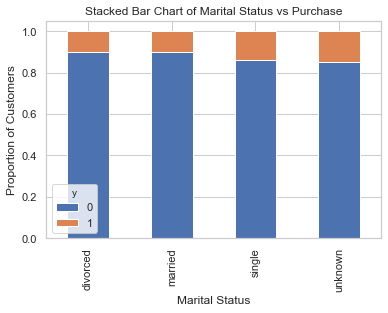

In [14]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

婚姻状况似乎不是好的预测因素。

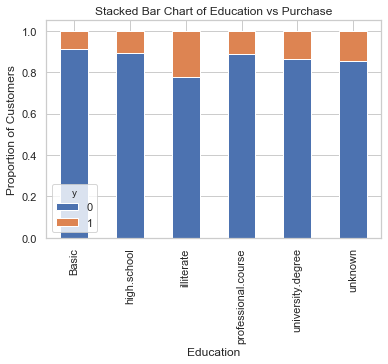

In [15]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

教育似乎是结果变量的良好预测指标。

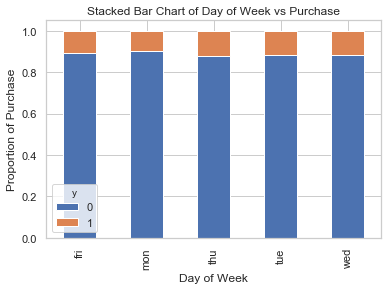

In [16]:
table=pd.crosstab(data.day_of_week,data.y)#.plot(kind='bar')
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Day of Week vs Purchase')
plt.xlabel('Day of Week')
plt.ylabel('Proportion of Purchase')
plt.savefig('dow_vs_purchase')

一周工作时间不是预测结果的良好预测因素。

In [17]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list = pd.get_dummies(data[var], prefix=var)
    data=data.join(cat_list)

In [18]:
data_final=data.drop(cat_vars, axis=1)
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

# 使用SMOTE进行过采样
创建我们的训练数据后，我将使用SMOTE算法（合成少数过采样技术）对已经开户的用户进行上采样。 在高层次上，SMOTE：

    通过从次要类（已经开户的用户）创建合成样本而不是创建副本来工作。
    随机选择一个k-最近邻居并使用它来创建一个类似但随机调整的新观察结果。
    
使用如下命令安装:
conda install -c conda-forge imbalanced-learn

In [21]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y'].values.ravel()

from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("过采样以后的数据量: ",len(os_data_X))
print("未开户的用户数量: ",len(os_data_y[os_data_y['y']==0]))
print("开户的用户数量: ",len(os_data_y[os_data_y['y']==1]))
print("未开户的用户数量的百分比: ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("开户的用户数量的百分比: ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

过采样以后的数据量:  51134
未开户的用户数量:  25567
开户的用户数量:  25567
未开户的用户数量的百分比:  0.5
开户的用户数量的百分比:  0.5


现在我们拥有完美平衡的数据！ 您可能已经注意到我仅对训练数据进行了过采样

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(os_data_X, os_data_y.values.reshape(-1))

C:\Users\76344\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
y_pred = logreg.predict(X_test)
print('在测试数据集上面的预测准确率: {:.2f}'.format(logreg.score(X_test, y_test)))

在测试数据集上面的预测准确率: 0.86


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92     10981
           1       0.44      0.88      0.59      1376

    accuracy                           0.86     12357
   macro avg       0.71      0.87      0.75     12357
weighted avg       0.92      0.86      0.88     12357



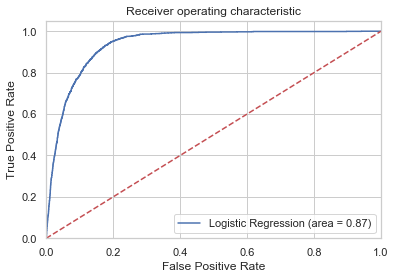

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()